In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import numpy as np
import os, shutil
import pandas, csv, json
import random
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({u'font.sans-serif':['simhei']})
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import scipy
import math
from scipy.stats import genextreme as gev, gumbel_r, norm, gompertz
from scipy.special import gamma, factorial

from constants import * 
from utils import *

In [97]:

args = ["--no=-1"]
# args = ["--no=-1", "--skip_site"]
opt = parse(args)
same_seeds(opt.seed)
origin_path = "data/origin/valid"
thres_path  = "data/thres/valid"

In [114]:

memory_size = 40
window_size = 24
source_size = 24
target_size = 8
def plot(sitename, a_path, a_label, b_path=None, b_label=None):
    a_pred = np.load(f"{a_path}/{sitename}.npy")
    b_pred = np.load(f"{b_path}/{sitename}.npy")
    true     = np.load(f"{origin_path}/{sitename}.npy")
    thres = np.load(f"{thres_path}/{sitename}.npy")
    date = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    
    print(a_pred.shape, b_pred.shape, true.shape)
    true  = true [memory_size+window_size+source_size+target_size-1:, 7:8]
    thres = thres[memory_size+window_size+source_size+target_size-1:, 7:8]
    date  = date [memory_size+window_size+source_size+target_size-1:]
    a_pred = a_pred[memory_size+window_size-1:]
    st = - 24 * 30 * 11
    true   = true  [st:, 7:8]
    thres  = thres [st:, 7:8]
    date   = date  [st:]
    a_pred = a_pred[st:]
    b_pred = b_pred[st:]
    
    # Calculate QA
    a_rmse = np.sqrt(np.mean((a_pred-true)*(a_pred-true)))
    b_rmse = np.sqrt(np.mean((b_pred-true)*(b_pred-true)))
    print(f"rmse {a_label}: {a_rmse: .4f}")
    print(f"rmse {b_label}: {b_rmse: .4f}")
    
#     st = 24 * 30 * i
#     ed = 24 * 30 * (i+1)
    st = np.where(date_ == '2019/05/01 00:00')[0][0]
    ed = st + 24 * 28
    a_pred   = a_pred[st:ed]
    b_pred   = b_pred[st:ed]
    true     = true[st:ed]
    thres    = thres[st:ed]
    x        = date[st:ed]
    
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.plot(x, a_pred,    color='red',   lw=2,  alpha=.5, label=a_label)
    ax.plot(x, b_pred,    color='green', lw=2,  alpha=.5, label=b_label)
    ax.plot(x, true,      color='blue',  lw=1,  alpha=.9, label='true')
    ax.plot(x, thres,     color='black', lw=1,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    return a_rmse, b_rmse

# site_list = ['陽明','淡水','士林','中山','萬華','觀音','古亭','永和','板橋','土城','新店']
site_list = ['陽明','中山','萬華','古亭']
tables = {}
for sitename in site_list:
#     print(sitename)
    no_a = 90
    no_b = 92
    i=0
    a_rmse, b_rmse = plot(sitename, 
     f"split_method/results/{no_a}", f"{no_a}", 
     f"split_method/results/{no_b}", f"{no_b}")

#     for i in range(12):
#         a_rmse, b_rmse = plot(sitename, 
#              f"split_method/results/{no_a}", f"{no_a}", 
#              f"split_method/results/{no_b}", f"{no_b}")
#         tables[sitename] = (a_rmse, b_rmse)
#     print("hist")
#     hist(sitename, f"split_method/results/{47}_all", "47", f"split_method/results/{48}_all", "48")
#     break
# print(f"\
# | site name |  rmse |\n\
# | - | - |\n\
# | 陽明 | {tables['陽明'][0]:.4f} |\n\
# | 中山 | {tables['中山'][0]:.4f} |\n\
# | 萬華 | {tables['萬華'][0]:.4f} |\n\
# | 古亭 | {tables['古亭'][0]:.4f} |")
# print(f"\
# | site name |  rmse |\n\
# | - | - |\n\
# | 陽明 | {tables['陽明'][1]:.4f} |\n\
# | 中山 | {tables['中山'][1]:.4f} |\n\
# | 萬華 | {tables['萬華'][1]:.4f} |\n\
# | 古亭 | {tables['古亭'][1]:.4f} |")

(8728, 8, 1) (8665, 1) (8760, 16)


ValueError: operands could not be broadcast together with shapes (7920,8,1) (7920,0) 

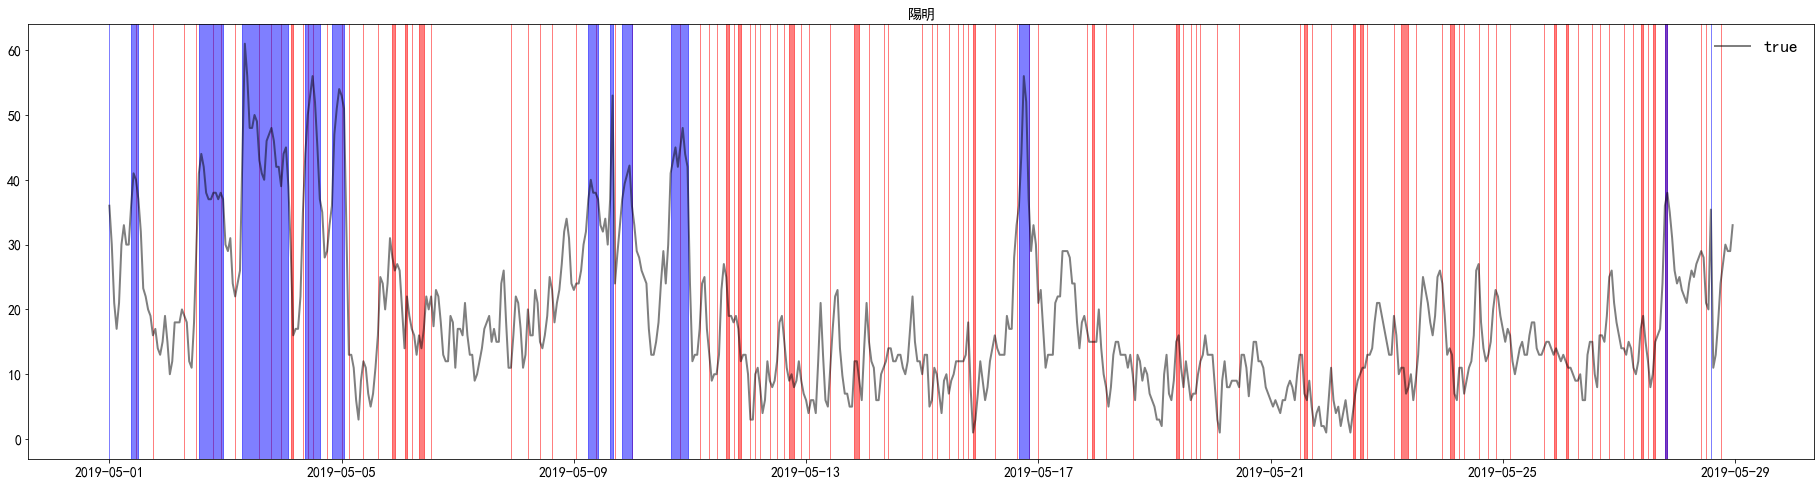

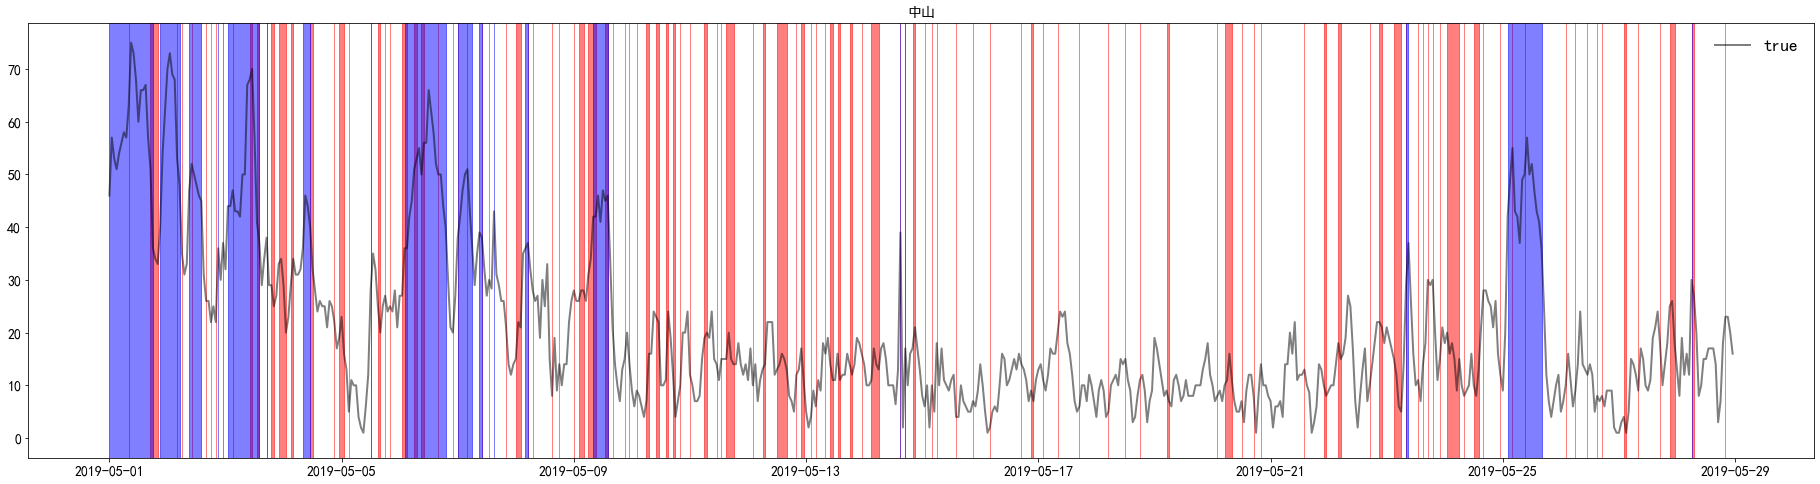

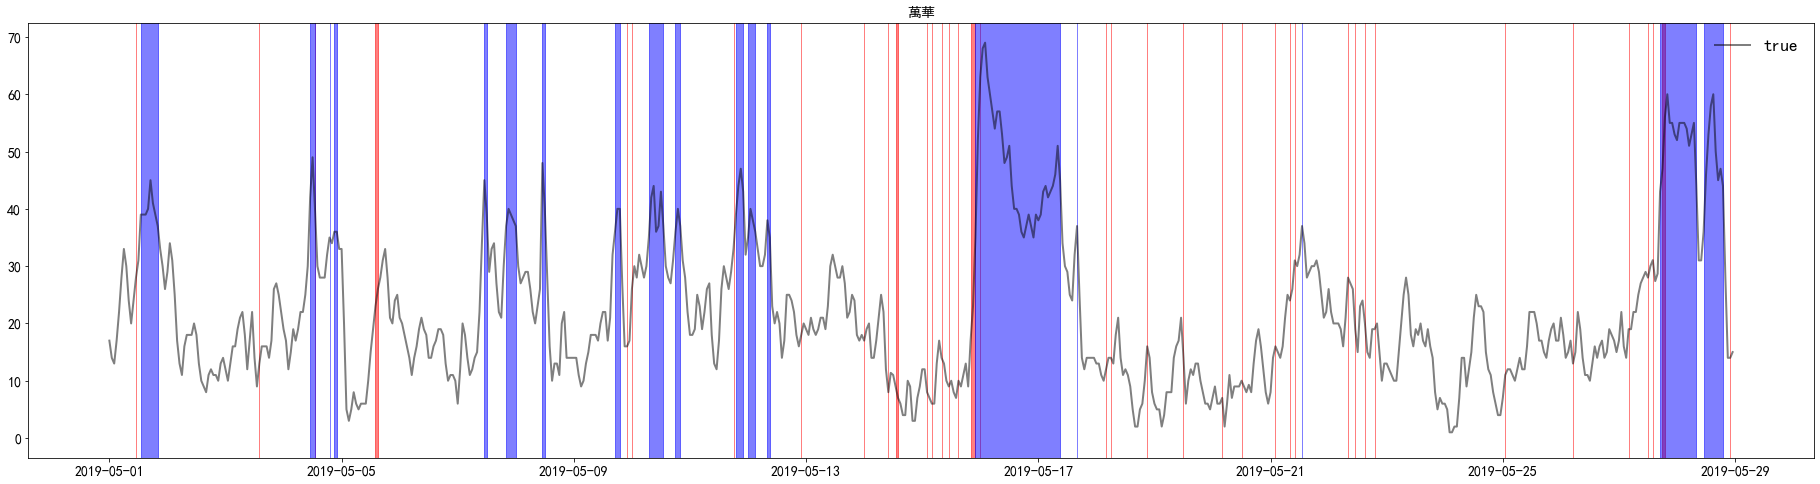

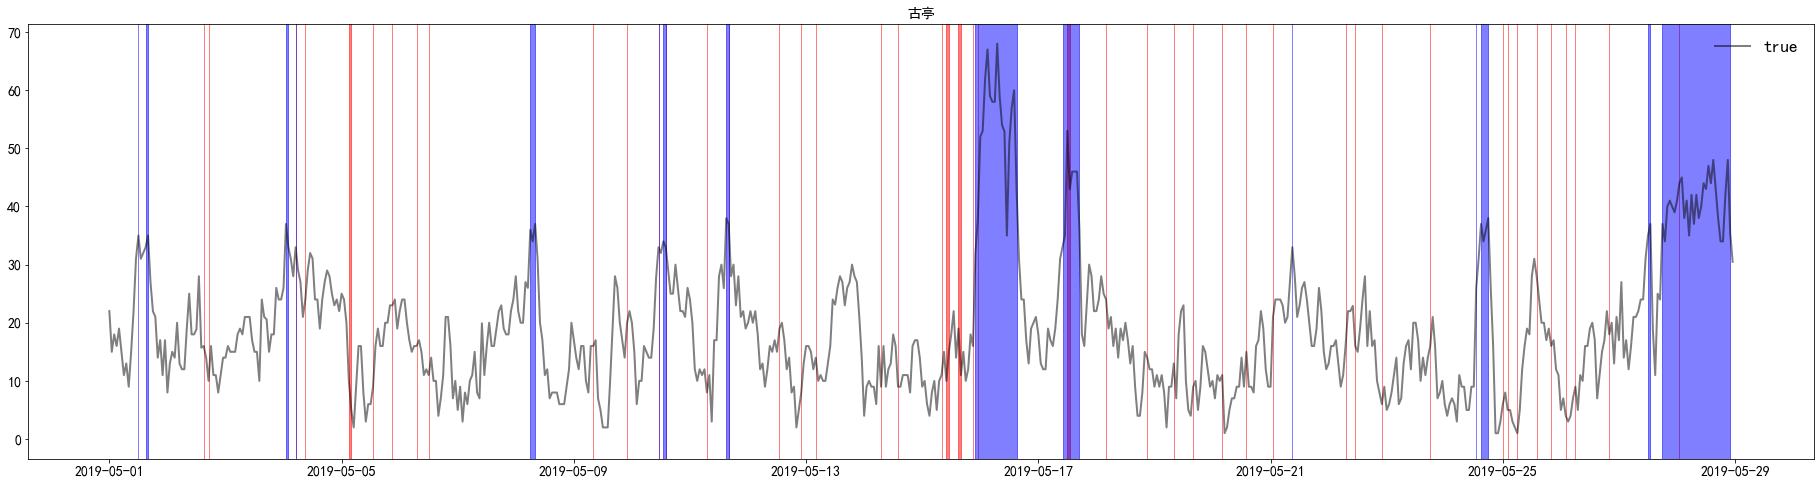

In [137]:
def get_scope(x, y):
    x_list, y_list = [], []
    index = np.where(y==1)[0]
    if len(index) == 0:
        return x_list, y_list
    st = index[0]
    ed = index[0]
    for i in range(1, len(index)):
        obj = index[i]
        if obj == ed + 1:
            ed = obj
        else:
            x_list.append(x[st:ed+1])
            y_list.append(y[st:ed+1])
            st, ed = obj, obj
    x_list.append(x[st:ed+1])
    y_list.append(y[st:ed+1])
    return x_list, y_list

def get_mask(data, thres):
    dif_data = data[1:, 7] - data[:-1, 7]
    index = np.argwhere(dif_data>=15)[:, 0] + 1
    mask = np.zeros((data.shape[0]))
    mask[index] = 1
    mask[data[:,7]>=thres[:,7]] = 1
    return mask
    
# For classification output
def plot(sitename, a_path, a_label):
    # -------------------------------
    # Load data
    # -------------------------------
    if mode == 1:
        a_pred = np.load(f"{a_path}/{sitename}_class.npy")[:, :, 0]
    else:
        a_pred = np.load(f"{a_path}/{sitename}.npy")[:, :, 0]

    true   = np.load(f"{origin_path}/{sitename}.npy")
    thres  = np.load(f"{thres_path}/{sitename}.npy")
    date   = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    mask   = get_mask(true, thres)
    # -------------------------------
    # Shift data
    # -------------------------------
    
    a_pred = a_pred[:, shift]
#     print(a_pred.shape, true.shape)
    if mode == 2:
        true   = true [memory_size+source_size+target_size+shift:, 7]
        thres  = thres[memory_size+source_size+target_size+shift:, 7]
        date_  = date [memory_size+source_size+target_size+shift:]
        mask   = mask [memory_size+source_size+target_size+shift:]
    elif mode == 1:
        true   = true [memory_size+window_size+source_size+target_size+shift:, 7]
        thres  = thres[memory_size+window_size+source_size+target_size+shift:, 7]
        date_  = date [memory_size+window_size+source_size+target_size+shift:]
        mask   = mask [memory_size+window_size+source_size+target_size+shift:]
    elif shift < -1:
        true   = true [source_size+target_size+shift:shift+1, 7]
        thres  = thres[source_size+target_size+shift:shift+1, 7]
        date_  = date [source_size+target_size+shift:shift+1]
        mask   = mask [source_size+target_size+shift:shift+1]
    else:
        true   = true [source_size+target_size-1:, 7]
        thres  = thres[source_size+target_size-1:, 7]
        date_  = date [source_size+target_size-1:]
        mask   = mask [source_size+target_size-1:]
#     print(a_pred.shape, true.shape, thres.shape)
#     print(mask.shape, true.shape, a_pred.shape)
    
    # -------------------------------
    # Zoom data
    # -------------------------------
    st = np.where(date_ == '2019/05/01 00:00')[0][0]
    ed = st + 24 * 28
#     st = 0
#     ed = -1
    true   = true  [st:ed]
    thres  = thres [st:ed]
    mask   = mask  [st:ed]
    x      = date_ [st:ed]
    a_pred = a_pred[st:ed]
#     print(true, true.shape)
#     print(mask, mask.shape)
    # -------------------------------
    # Draw data
    # -------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.fill_between(x, 0, max(true), where=a_pred >= .5, 
                    color='red', alpha=0.5, transform=ax.get_xaxis_transform())
    ax.fill_between(x, 0, max(true), where=mask>.5, 
                    color='blue', alpha=0.5, transform=ax.get_xaxis_transform())
    ax.plot(x, true,      color='black',  lw=2,  alpha=.5, label='true')
#     ax.plot(x, thres,     color='black',  lw=2,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

site_list = ['陽明','中山','萬華','古亭']
method = ""
memory_size = 40
window_size = 24 
source_size = 24
target_size = 8
shift = -1 # -1 ... -target_size
mode = 1 # 2 for seq 1 for fudan 0 for others

for sitename in site_list:
#     print(sitename)
    no_a = 108
    plot(
        sitename, 
        f"split_method/results/{no_a}", f"{no_a}"
    )
#     break

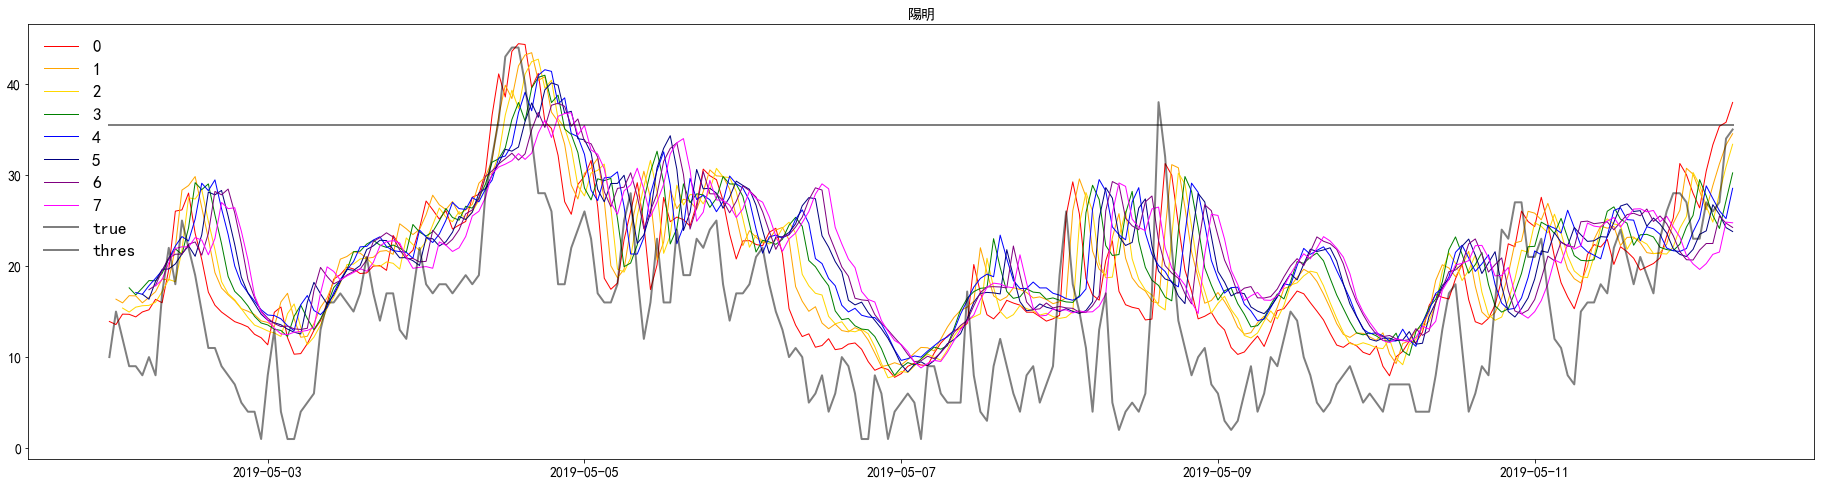

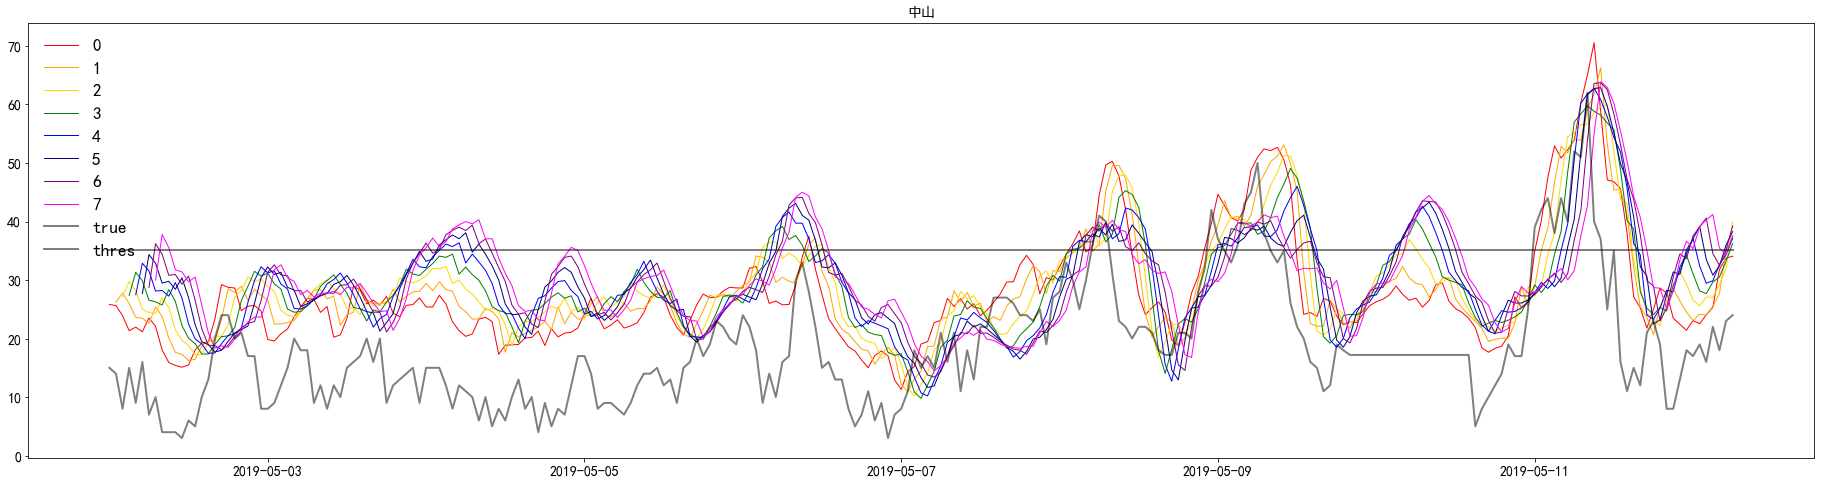

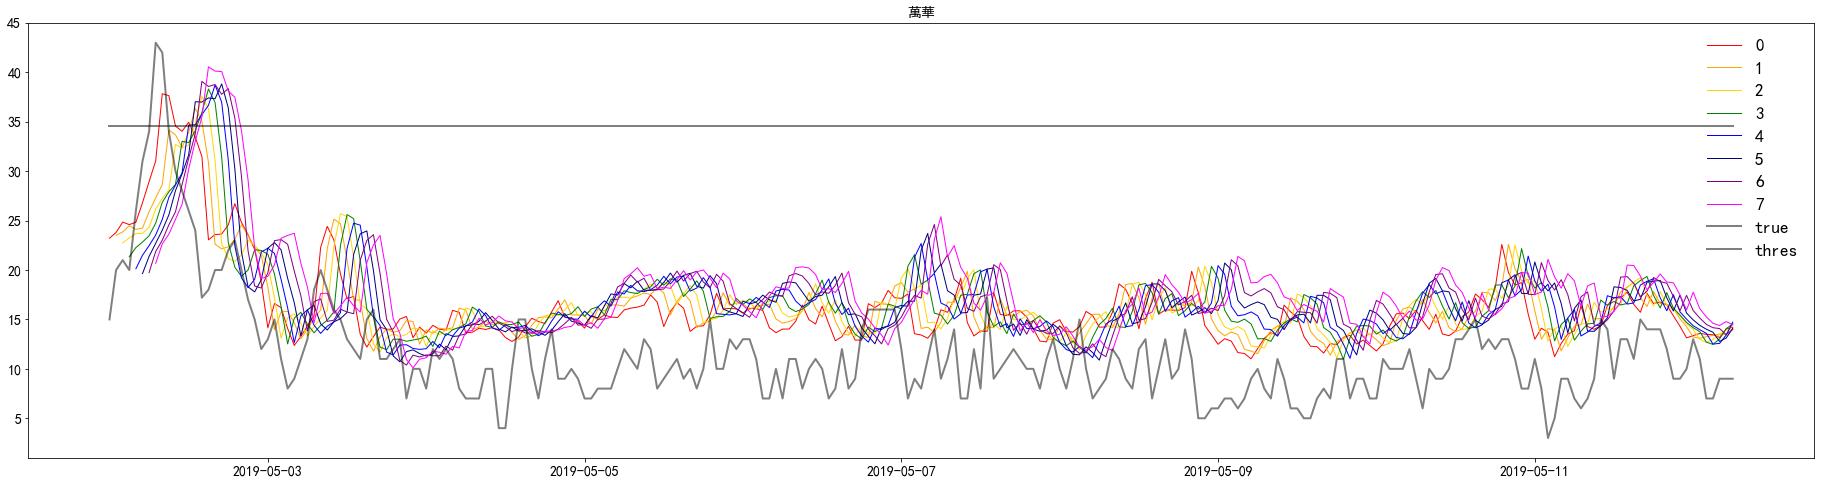

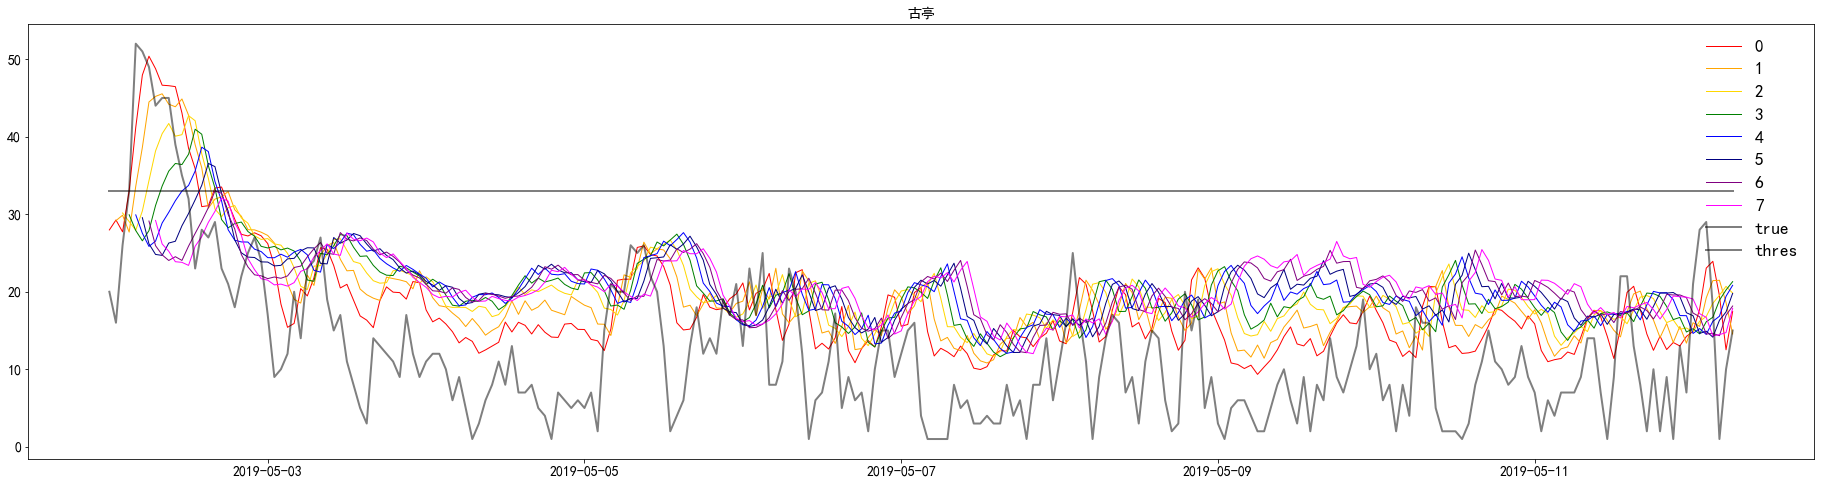

In [180]:
# For multiple output
def plot(sitename, a_path, a_label):
    a_pred = np.load(f"{a_path}/{sitename}.npy")
    true   = np.load(f"{origin_path}/{sitename}.npy")
    thres  = np.load(f"{thres_path}/{sitename}.npy")
    date   = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')

    a_pred0 = a_pred[:, 0]
    a_pred1 = a_pred[:, 1]
    a_pred2 = a_pred[:, 2]
    a_pred3 = a_pred[:, 3]
    a_pred4 = a_pred[:, 4]
    a_pred5 = a_pred[:, 5]
    a_pred6 = a_pred[:, 6]
    a_pred7 = a_pred[:, 7]
    shift  = true [source_size-8:-8, 7:8]
    true   = true [source_size:, 7:8]
    thres  = thres[source_size:, 7:8]
    date_  = date [source_size:]
    date0  = date [source_size+target_size-8:-8]
    date1  = date [source_size+target_size-7:-7]
    date2  = date [source_size+target_size-6:-6]
    date3  = date [source_size+target_size-5:-5]
    date4  = date [source_size+target_size-4:-4]
    date5  = date [source_size+target_size-3:-3]
    date6  = date [source_size+target_size-2:-2]
    date7  = date [source_size+target_size-1:-1]
    
    # Calculate QA
#     a_rmse = np.sqrt(np.mean((a_pred-true)*(a_pred-true)))
#     print(f"rmse {a_label}: {a_rmse: .4f}")
    
    st = 24 * 30 * i
    ed = 24 * 30 * i + 24 * 10
    a_pred0   = a_pred0[st:ed+7]
    a_pred1   = a_pred1[st:ed+6]
    a_pred2   = a_pred2[st:ed+5]
    a_pred3   = a_pred3[st:ed+4]
    a_pred4   = a_pred4[st:ed+3]
    a_pred5   = a_pred5[st:ed+2]
    a_pred6   = a_pred6[st:ed+1]
    a_pred7   = a_pred7[st:ed]
    x0        = date0 [st:ed+7]
    x1        = date1 [st:ed+6]
    x2        = date2 [st:ed+5]
    x3        = date3 [st:ed+4]
    x4        = date4 [st:ed+3]
    x5        = date5 [st:ed+2]
    x6        = date6 [st:ed+1]
    x7        = date7 [st:ed]
    true      = true  [st:ed+7]
    thres     = thres [st:ed+7]
    x         = date_ [st:ed+7]
    shift     = shift [st:ed+7] 
    
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.plot(x0, a_pred0,    color='red',   lw=1,            label='0')
    ax.plot(x1, a_pred1,    color='orange',   lw=1,            label='1')
    ax.plot(x2, a_pred2,    color='gold',   lw=1,            label='2')
    ax.plot(x3, a_pred3,    color='green',   lw=1,            label='3')
    ax.plot(x4, a_pred4,    color='blue',   lw=1,            label='4')
    ax.plot(x5, a_pred5,    color='navy',   lw=1,            label='5')
    ax.plot(x6, a_pred6,    color='purple',   lw=1,            label='6')
    ax.plot(x7, a_pred7,    color='fuchsia',   lw=1,            label='7')
#     ax.plot(x, shift,    color='dodgerblue',   lw=2, alpha=5,  label='shift')
    ax.plot(x, true,      color='black',  lw=2,  alpha=.5, label='true')
    ax.plot(x, thres,     color='black',  lw=2,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

site_list = ['陽明','中山','萬華','古亭']
method = ""
source_size = 24
target_size = 8

for sitename in site_list:
#     print(sitename)
    no_a = 91
    i=4
    plot(
        sitename, 
        f"split_method/results/{no_a}", f"{no_a}"
    )
#     break

rmse 76:  5.0649


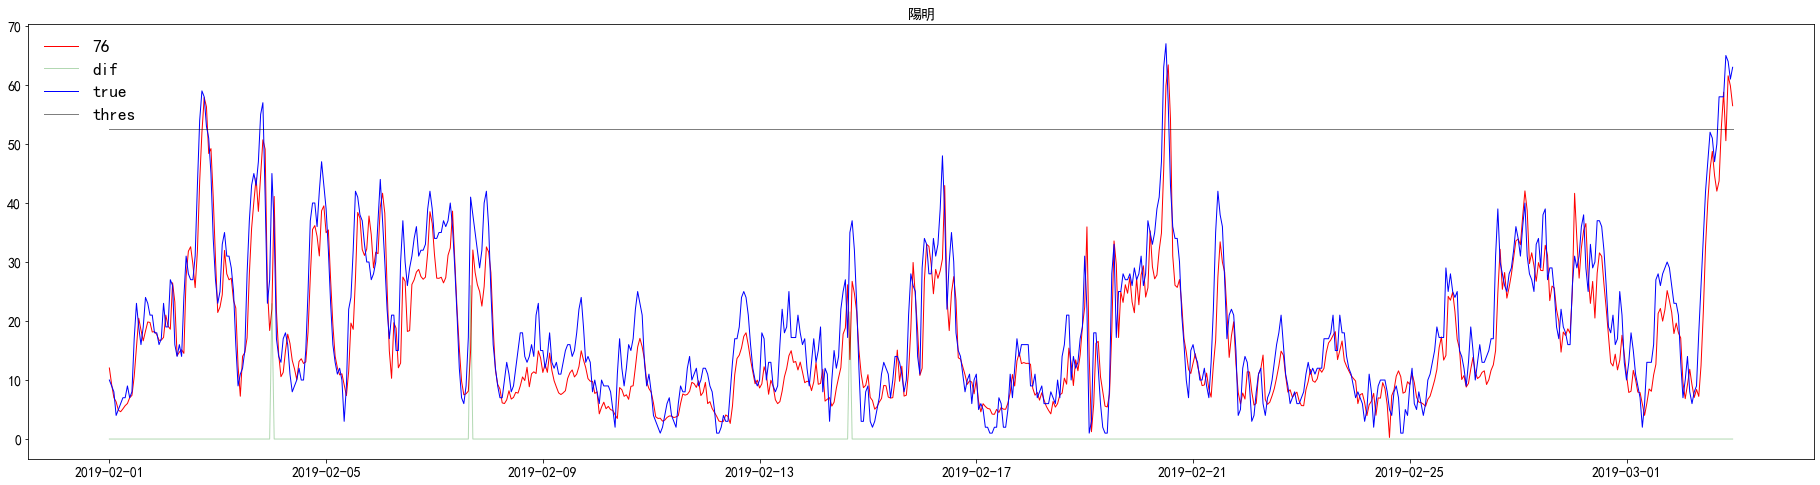

rmse 76:  6.8021


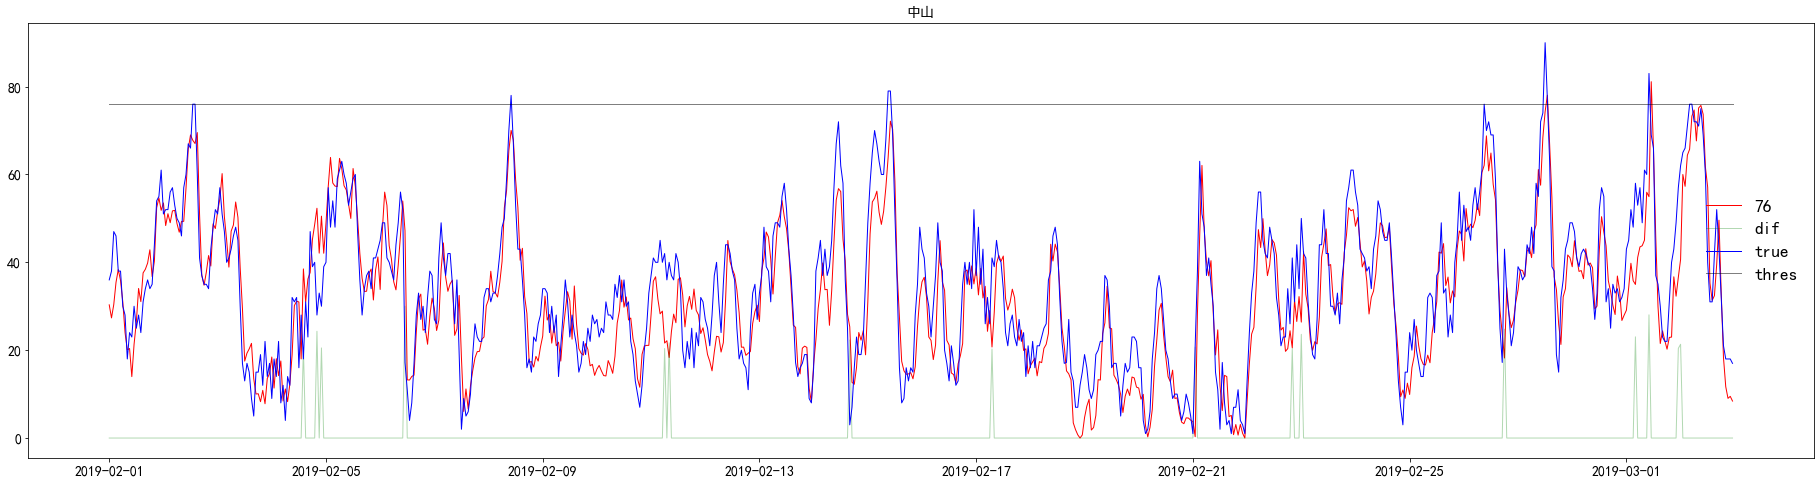

rmse 76:  4.2224


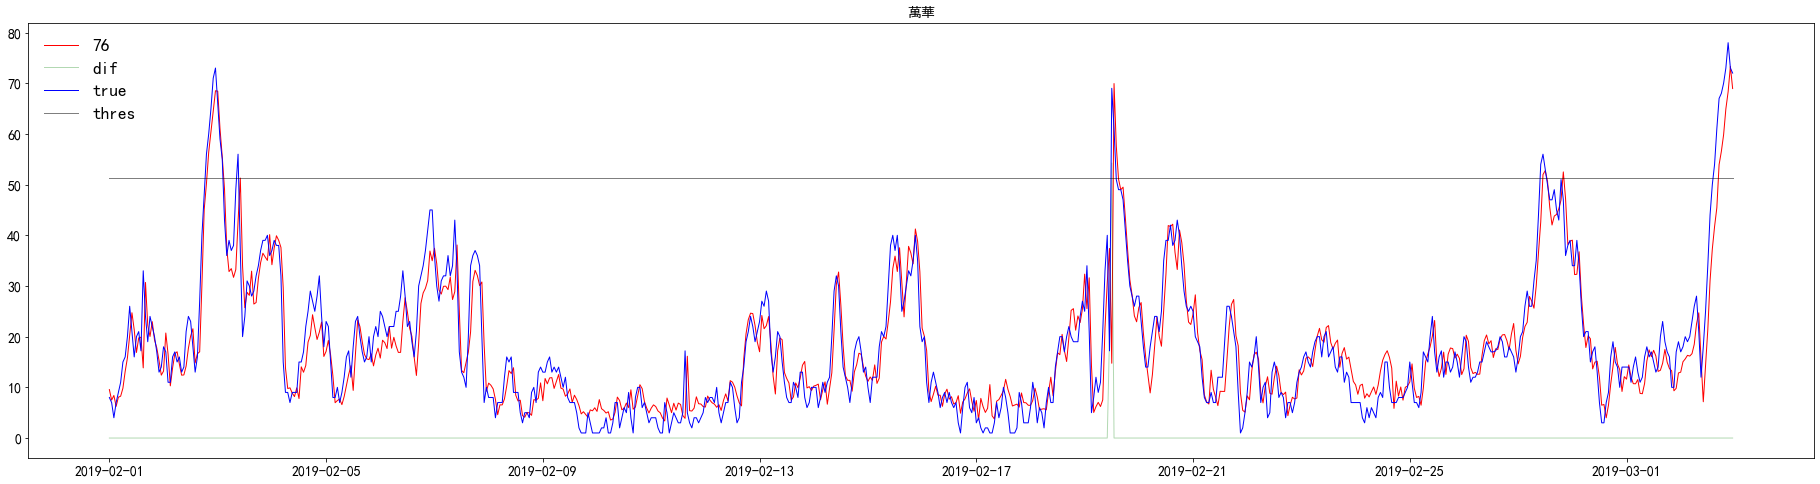

rmse 76:  5.9521


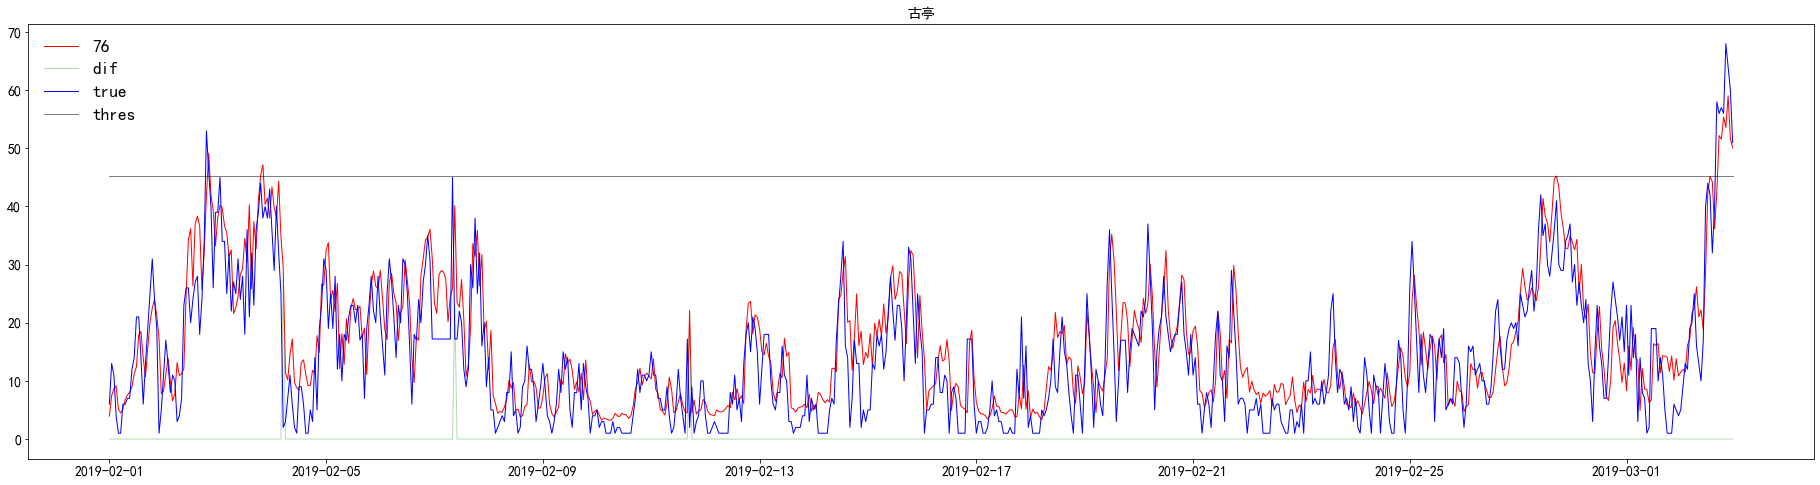

In [135]:
# For Unet
def plot(sitename, a_path, a_label):
    a_pred = np.load(f"{a_path}/{sitename}.npy")
    true     = np.load(f"{origin_path}/{sitename}.npy")
    thres = np.load(f"{thres_path}/{sitename}.npy")
    date = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    
#     print(a_pred.shape, true.shape, true.shape[0]-a_pred.shape[0])
    true  = true [source_size:, 7:8]
    thres = thres[source_size:, 7:8]
    date  = date [source_size:]
    
    # Calculate QA
    a_rmse = np.sqrt(np.mean((a_pred-true)*(a_pred-true)))
    print(f"rmse {a_label}: {a_rmse: .4f}")
    
    st = 24 * 30 * i
    ed = 24 * 30 * (i+1)
#     ed = 24 * 30 * i + 24 * 10
    a_pred   = a_pred[st:ed]
    true     = true  [st:ed]
    thres    = thres [st:ed]
    x        = date  [st:ed]
    dif      = np.abs(a_pred - true)
    dif[dif<=20] = 0
    
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.plot(x, a_pred,    color='red',   lw=1,  label=a_label)
    ax.plot(x, dif,       color='green',   lw=1,  alpha=.3, label='dif')
    ax.plot(x, true,      color='blue',  lw=1,  label='true')
    ax.plot(x, thres,     color='black', lw=1,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

site_list = ['陽明','中山','萬華','古亭']
method = ""
source_size = 24

for sitename in site_list:
#     print(sitename)
    no_a = 76
    i=1
    plot(sitename, 
         f"split_method/results/{no_a}_unet", f"{no_a}")
#     break

In [ ]:
def hist(sitename, a_path, a_label, b_path=None, b_label=None):
    
    def get_hist(data):
        x = np.arange(data.max())
        gev_fit = gev.fit(data)
        gev_hist = gev.pdf(x, gev_fit[0], gev_fit[1], gev_fit[2])
        norm_fit = norm.fit(data)
        norm_hist = norm.pdf(x, norm_fit[0], norm_fit[1])
        return x, gev_hist, norm_hist
        
    true   = np.load(f"{origin_path}/{sitename}.npy").astype(np.int)
    a_pred = np.load(f"{a_path}/{sitename}.npy").astype(np.int)
    
    true = true[source_size+target_size:, 7:8]
    a_pred[a_pred<0] = 0
    true[true<0] = 0
    
    true_x, true_gev, true_norm = get_hist(true)
    a_x, a_gev, a_norm = get_hist(a_pred) 
    if b_path:
        b_pred = np.load(f"{b_path}/{sitename}.npy").astype(np.int)
        b_pred[b_pred<0] = 0
        b_x, b_gev, b_norm = get_hist(b_pred)
        
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    
    ax.hist(true, 
        np.max(true),
        alpha=.4,
        label = 'true',
        color='blue',
        density=True,
        )
    ax.hist(a_pred, 
        np.max(a_pred),
        alpha=.4,
        label=a_label,
        color='red',
        density=True,
        )
    
#     ax.plot(a_x, a_gev,  color='red', lw=1, alpha=1,   linestyle='-.', label=f'{a_label}_gev')
#     ax.plot(a_x, a_norm, color='green', lw=1, alpha=1, linestyle='-.', label=f'{a_label}_norm')
    ax.plot(true_x, true_gev,  color='blue', lw=1, alpha=1,  label='true_gev')
    ax.plot(true_x, true_norm, color='dodgerblue', lw=1, alpha=1,  label='true_norm')
    if b_path:
        ax.plot(b_x, b_gev,  color='forestgreen', lw=3, alpha=1, linestyle=':', label=f'{b_label}_gev')
        ax.plot(b_x, b_norm, color='lime', lw=3, alpha=1, linestyle=':', label=f'{b_label}_norm')
        ax.hist(b_pred, 
            np.max(b_pred),
            alpha=.4,
            label=b_label,
            color='green',
            density=True,
        )

    
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [ ]:
all_path = "data/origin/all"
thres_path  = "data/thres/train"

site_list = ['陽明','淡水','士林','中山','萬華','觀音','古亭','永和','板橋','土城','新店']
# site_list = ['土城']
for sitename in site_list:
#     print(sitename)
    a_pred = np.load(f"{all_path}/{sitename}.npy")[:, 7]
    thres = np.load(f"{thres_path}/{sitename}.npy")[:, 7]
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    x = np.arange(a_pred.shape[0])
    ax.plot(x, a_pred,    color='blue', alpha=.5,  lw=1,  label='data')
    x = np.arange(thres.shape[0])
    ax.plot(x, thres,     color='black', lw=1,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')

    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylim(top=150)
    plt.yticks(fontsize=14)
    plt.show()
#     break

陽明
196.0


<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


norm kl=2.050e-01 loc= 18.38 scale= 13.53
gumbel_r kl=6.149e-02 loc= 12.47 scale= 9.69
gev kl=4.798e-02 shape= -0.14 loc= 11.75 scale= 9.09


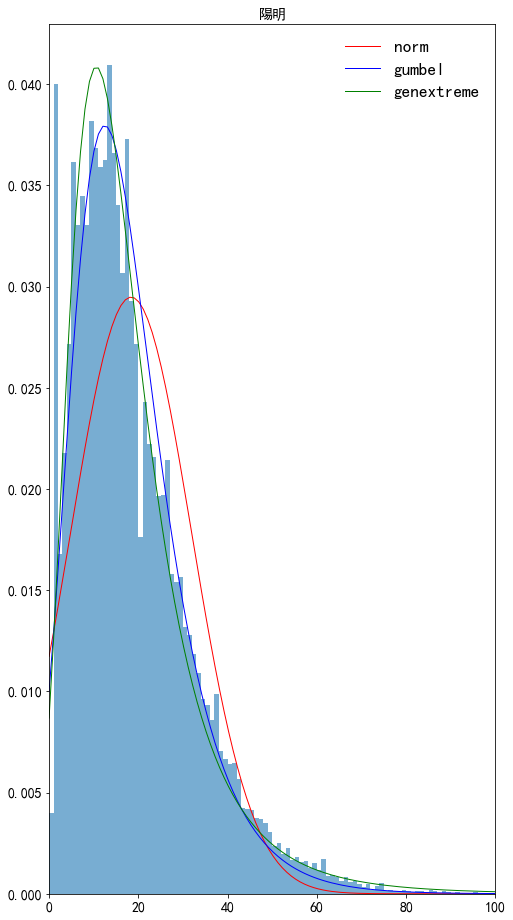

中山
171.0


<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


norm kl=1.956e-01 loc= 26.41 scale= 19.43
gumbel_r kl=7.082e-02 loc= 17.79 scale= 14.22
gev kl=5.932e-02 shape= -0.14 loc= 16.72 scale= 13.29


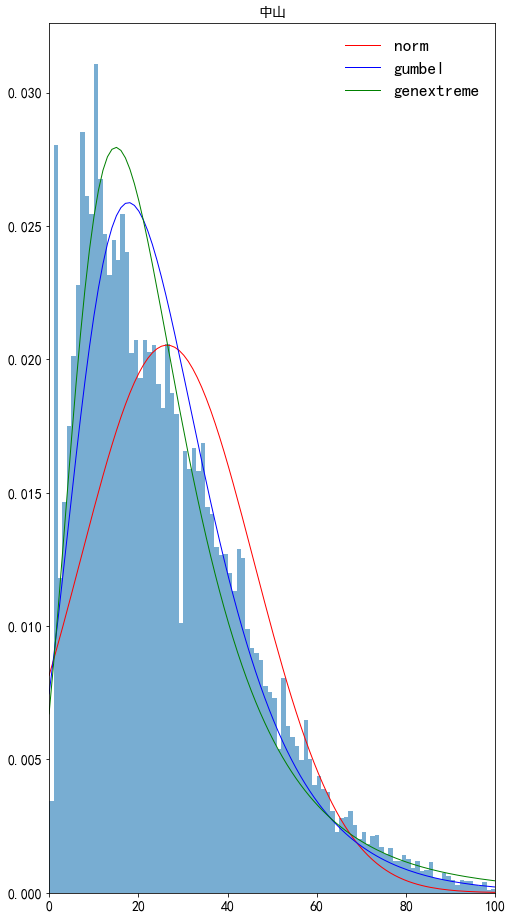

萬華
124.0


<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


norm kl=2.074e-01 loc= 18.52 scale= 12.76
gumbel_r kl=4.627e-02 loc= 13.04 scale= 8.96
gev kl=3.058e-02 shape= -0.14 loc= 12.38 scale= 8.42


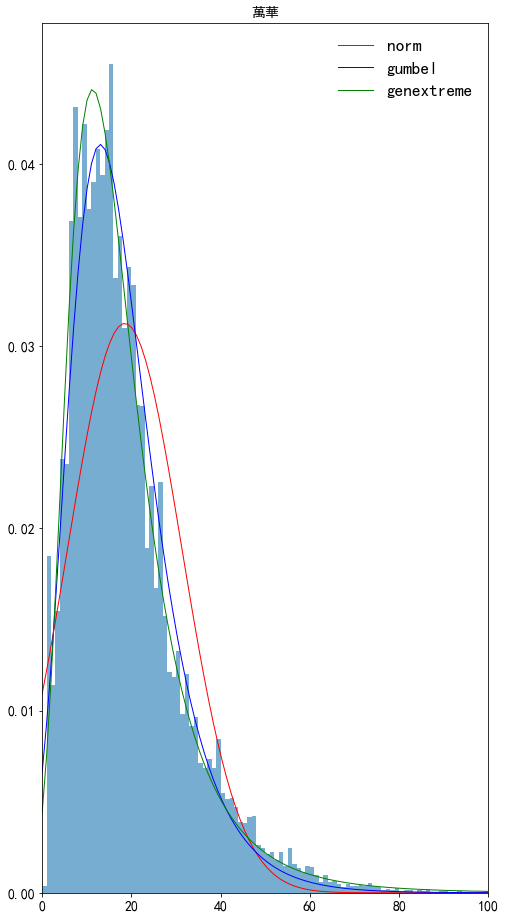

古亭
167.0


<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-112-b6b8c1a068a8>:8: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


norm kl=2.115e-01 loc= 16.19 scale= 11.67
gumbel_r kl=5.386e-02 loc= 11.18 scale= 8.26
gev kl=4.162e-02 shape= -0.12 loc= 10.64 scale= 7.83


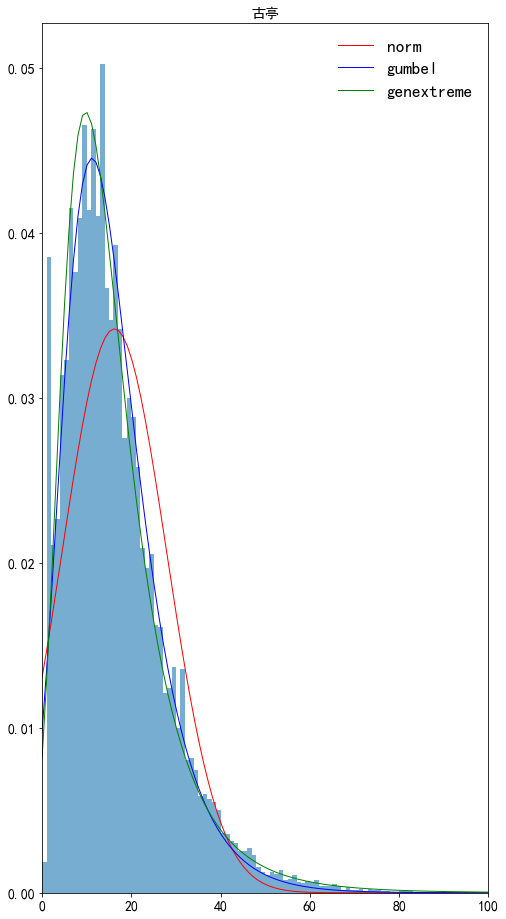

In [112]:
def gussion(x, position, width, height):
    return  height * math.sqrt(2*math.pi) * width * scipy.stats.norm.pdf(x, position, width)

def extreme(x, position, width, height, c=-0.1):
    return  height * math.sqrt(2*math.pi) * width * gev.pdf(x, c, position, width)

def kld(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

origin_all_path = opt.origin_all_dir

sitenames = ['陽明','中山','萬華','古亭']
for idx, sitename in enumerate(sitenames):
    
    if opt.skip_site and sitename not in sample_sites:
        continue
    print(sitename)
    read_path = os.path.join(origin_all_path, f"{sitename}.npy")
    data = np.load(read_path)[:, 7].astype(np.int)

    data[data<0] = 0
    ratio = 1
    div = 8
    max_bin = np.max(data) // ratio + 1
    
    bins = [i * ratio for i in range(max_bin)]
    hist, _ = np.histogram(data, bins=bins, density=True)
#     try:
#         zero_list = np.where(hist==0)[0]
#         max_index = zero_list[0] if zero_list[0] != 0 else zero_list[1]
#         hist = hist[:max_index]
#     except:
#         pass
# #     print(hist)
#     try:
#         pos = np.argmax(hist) * ratio
#     except:
#         print(hist)
#     if pos == 0:
#         try:
#             pos = np.argmax(hist[1:]) * ratio
#         except:
#             print(pos, hist)
#     height = np.max(hist)
#     height = np.mean(hist[hist.argsort()[-3:][::-1]])
#     width = (len(hist)-pos)/ratio/div
#     print("loc:", pos, "scale:", width, "height:", height)
    
    # Limit boundary
#     data[data>(len(hist)*2)] = 0
    max_bin = np.max(data) // ratio + 1
    bins = [i * ratio for i in range(max_bin)]
    
    # Prepare distribution
    x = np.linspace(0, np.max(data), np.max(data))
    print(np.max(x))
    
    gev_fit = gev.fit(data)
    gev_dist = gev.pdf(x, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_kl = kld(hist, gev_dist)
    
    gumbel_r_fit = gumbel_r.fit(data)
    gumbel_r_dist = gumbel_r.pdf(x, gumbel_r_fit[0], gumbel_r_fit[1])
    gumbel_r_kl = kld(hist, gumbel_r_dist)
    
#     gompertz_fit = gompertz.fit(data)
#     gompertz_dist = gompertz.pdf(x, gompertz_fit[0], gompertz_fit[1], gompertz_fit[2])
#     gompertz_kl = kld(hist, gompertz_dist)
    
    norm_fit = norm.fit(data)
    norm_dist = norm.pdf(x, norm_fit[0], norm_fit[1])
    norm_kl = kld(hist, norm_dist)
    
    
    print(f'norm kl={norm_kl:.3e}'                                         ,'loc=',round(norm_fit[0],2), 'scale=',round(norm_fit[1],2))
    print(f'gumbel_r kl={gumbel_r_kl:.3e}',                                    'loc=',round(gumbel_r_fit[0],2), 'scale=',round(gumbel_r_fit[1],2))
#     print(f'gompertz kl={gompertz_kl:.3e}', 'shape=',round(gompertz_fit[0],2), 'loc=',round(gompertz_fit[1],2), 'scale=',round(gompertz_fit[2],2))
    print(f'gev kl={gev_kl:.3e}',      'shape=',round(gev_fit[0],2),      'loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2))
    
    
    # Plot 
    fig, ax = plt.subplots(1, 1, figsize=(8,16))
    ax.plot(x, norm_dist,    color='red', lw=1, alpha=1, label='norm')
    ax.plot(x, gumbel_r_dist,    color='blue', lw=1, alpha=1, label='gumbel')
#     ax.plot(x, gompertz_dist,    color='purple', lw=1, alpha=1, label='gompertz')
    ax.plot(x, gev_dist,     color='green', lw=1, alpha=1, label='genextreme')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    plt.xlim(0, 100)
    
    ax.hist(data, 
            np.max(data),
#             bins=bins,
            alpha=0.6,
            density=True
            )
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
#     break
    

In [ ]:
# 國維的 code 

def GEV(x,u,sigma,k):
    z = ((x-u)/sigma)
    distribution = (1/sigma)*(np.exp(-(1+k*z)**(-1/k)))*((1+k*z)**(-1-1/k))
    return(distribution)
def plot(x,u,sigma,k):
    xx = np.arange(np.max(x))
    gev_fit = gev.fit(x)
    gev_pdf = gev.pdf(xx, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_estimator = GEV(xx,u=u,sigma=sigma,k=k)
#     gev_estimator = GEV(xx,u=gev_fit[1],sigma=gev_fit[2],k=gev_fit[0])
    print('loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2), 'shape=',round(gev_fit[0],2))
    plt.figure(figsize=(16,8))
    plt.hist(x, np.max(x), density=True, alpha=0.6, label='Data')
    plt.plot(xx, gev_pdf, 'r--', label='Scipy Auto Fit')
    plt.plot(xx, gev_estimator, 'b--', label='L-moments estimator')
    plt.legend()
    plt.show()

float_point = 4

sitename = "陽明"
read_path = os.path.join(origin_all_path, f"{sitename}.npy")
x = np.load(read_path)[:, 7].astype(np.int)
x[x<0] = 0

n = x.shape[0]
r = [0,1,2]
b_0=0;b_1=0;b_2=0
for i in range(n):
    b_0 = b_0+(   x[i] * ((i-r[0])/(n*(n-r[0])))   )
    b_1 = b_1+(   x[i] * ((i-r[0])*(i-r[1]))/(n*(n-r[0])*(n-r[1]))   )
    b_2 = b_2+(   x[i] * ((i-r[0])*(i-r[1])*(i-r[2]))/(n*(n-r[0])*(n-r[1])*(n-r[2]))   )
print(b_0,b_1,b_2)
lambda_1 = round(  b_0  ,float_point)
lambda_2 = round(  ((2*b_1) - b_0)  ,float_point)
lambda_3 = round(  ((6*b_2)-(6*b_1)+b_0)  ,float_point)
print('lambda_1=',lambda_1,'lambda_2=',lambda_2,'lambda_3=',lambda_3)
tau_3 = round(  lambda_3/lambda_2  ,float_point)
print('tau_3=',tau_3)
c = round(  (2/(3+tau_3)) - (np.log(2)/np.log(3))  ,float_point)
print('c=',c)
k = round(  (7.8590*c)+(2.9554* (c**2))  ,float_point)    #(7.8590*c)+(2.9554* (c**2))
print('k=',k)
a = round(    ((lambda_2*k) / ((1-(2**-k)) * float(gamma(1+k))))   ,float_point)
print('scale=',a)
xi = round(    lambda_1 - ((a/k)*(float(gamma(1+k)-1)))   ,float_point)
print('loc=',xi)
plot(x,u=xi,sigma=a*2,k=k)
#Gumbel's type I (k=0), Frechet's type II (k<0), Weibull or type III (k>0)
#x = np.arange(35)
#for k not equal 0 , x < xi + (a/k)
#gev_cdf = np.exp(-((1-(k*((x-xi)/a)))**(1/k)))

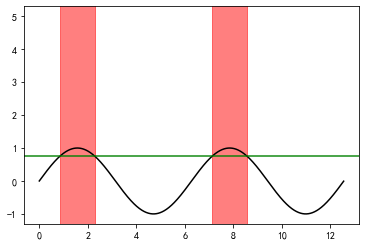

In [81]:
fig, ax = plt.subplots()
x = np.arange(0, 4 * np.pi, 0.01)
y = np.sin(x)
ax.plot(x, y, color='black')

threshold = 0.75
ax.axhline(threshold, color='green', lw=2, alpha=0.7)
ax.fill_between(x, 0, 5, where=y > threshold,
                color='red', alpha=0.5, transform=ax.get_xaxis_transform())

In [151]:
origin_path = "data/origin/train"
thres_path  = "data/thres/train"
delta       = 10
# dates       = pd.date_range(start="2014-01-01 00:00",end="2018-12-31 23:00", freq='H')
for site in ['陽明','中山','萬華','古亭']:
    print(site)
    data  = np.load(os.path.join(origin_path, f"{site}.npy"))
    thres = np.load(os.path.join( thres_path, f"{site}.npy"))[:, 7]
    print(f"Winter threshold: {thres[0]:.1f}, Summer threshold: {thres[24*190]:.1f}")
    s_thres = thres[24*190]
    w_thres = thres[0]
    s_index = np.isin(data[:, -3], [4,5,6,7,8,9])
    w_index = np.isin(data[:, -3], [1,2,3,10,11,12])
    data = data[:, 7]

    index = np.argwhere(data>=thres)
    cnt = index.shape[0]
    print(f"# of Extreme Event: {cnt}, is {cnt / data.shape[0] * 100:.1f}%")
    dif_a = a[1:] - a[:-1]
    index = np.argwhere(dif_a>=delta)
    cnt += index.shape[0]
    print(f"# of Extreme Event: {cnt}, is {cnt / data.shape[0] * 100:.1f}%")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!")
    thres[w_index] = min(w_thres, 54)
    index = np.argwhere(data>=thres)
    cnt = index.shape[0]
    print(f"Constant # of Extreme Event: {cnt}, is {cnt / data.shape[0] * 100:.1f}%")
    dif_a = a[1:] - a[:-1]
    index = np.argwhere(dif_a>=delta)
    cnt = index.shape[0]
    print(f"Upper bound # of Extreme Event: {cnt}, is {cnt / data.shape[0] * 100:.1f}%")
    dif_a = abs(a[1:] - a[:-1])
    index = np.argwhere(dif_a>=delta)
    cnt = index.shape[0]
    print(f"Lower bound # of Extreme Event: {cnt}, is {cnt / data.shape[0] * 100:.1f}%")
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!")
#     for i in range(a.shape[0]-1):
#         if a[i] >= thres_a[i] or i in index:
#             cnt += 1
#     print(cnt, cnt / a.shape[0] * 100)

陽明
Winter threshold: 52.5, Summer threshold: 35.5
# of Extreme Event: 1960, is 4.5%
# of Extreme Event: 3229, is 7.4%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!
Constant # of Extreme Event: 1960, is 4.5%
Upper bound # of Extreme Event: 1269, is 2.9%
Lower bound # of Extreme Event: 2520, is 5.8%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!
中山
Winter threshold: 76.0, Summer threshold: 35.1
# of Extreme Event: 1764, is 4.0%
# of Extreme Event: 3033, is 6.9%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!
Constant # of Extreme Event: 5074, is 11.6%
Upper bound # of Extreme Event: 1269, is 2.9%
Lower bound # of Extreme Event: 2520, is 5.8%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!
萬華
Winter threshold: 51.3, Summer threshold: 34.6
# of Extreme Event: 1904, is 4.3%
# of Extreme Event: 3173, is 7.2%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!
Constant # of Extreme Event: 1904, is 4.3%
Upper bound # of Extreme Event: 1269, is 2.9%
Lower bound # of Extreme Event: 2520, is 5.8%
>>>>>>>>>>>>>>>>>>>>>>>>>>>>!!!!
古亭
Winter threshold: 45.3, Summer threshol